**Clone Repo**

In [0]:
from getpass import getpass
import os
%cd ~
user = getpass('Gitlab user')
password = getpass('Gitlab password')
os.environ['GIT_AUTH'] = user + ':' + password

!git clone https://$GIT_AUTH@gitlab.lrz.de/ge82yic/video_interpolation.git
%cd video_interpolation
!git checkout master
!git pull

/root
Gitlab user··········
Gitlab password··········
Cloning into 'video_interpolation'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 816 (delta 11), reused 0 (delta 0)
Receiving objects: 100% (816/816), 5.91 MiB | 2.16 MiB/s, done.
Resolving deltas: 100% (453/453), done.
/root/video_interpolation
Branch 'master' set up to track remote branch 'master' from 'origin'.
Switched to a new branch 'master'
Already up to date.


**Mount drive**

In [0]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/Logs/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Initialize Moving Mnist Test set**

In [0]:
def create_train_valid_test_split(data):
    train_data_len = int(data.shape[1]*0.8)
    valid_data_len = int(data.shape[1]*0.1)
    test_data_len = int(data.shape[1]*0.1)
    train_data = data[:, 0:train_data_len, :, :]
    valid_data = data[:, train_data_len:(valid_data_len+train_data_len), :, :]
    test_data = data[:, (train_data_len+valid_data_len):(train_data_len+valid_data_len+test_data_len), :, :]
    return train_data, valid_data, test_data

In [0]:
import numpy as np
import os,sys
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
data = np.load('/content/gdrive/My Drive/ADL4CV/Code_LSVG/mnist_test_seq.npy')
train_data, valid_data, test_data = create_train_valid_test_split(data)
transform = transforms.Resize(28)
toPil = transforms.ToPILImage()
toTensor = transforms.ToTensor()

**Set the desired options**

In [0]:
# Prediction mode
mode = "framerate_upsampling" # Options: past_video, future_video, framerate_upsampling, all
# Interpolation method
method = "linear" # Options: linear, quadratic, cubic, all
# PCA (Principal Component Analysis)
use_pca = False
use_nonpca = True
assert use_pca or use_nonpca, "user_pca and use_nonpca can't both be false!"
# Result logging
log = True
# Number of input & output frames for the video generation
num_input = 2
num_output = 10
#assert (num_input == 2) or (num_input == 4) or (num_input == 10), "Only 2, 4 or 10 input frames supported right now"
# Pick custom frames from the input
use_custom_frames = True
custom_frames = [4, 9]
if use_custom_frames:
  assert len(custom_frames) == num_input, "Number of custom frames must number of desired input frames"
# Select test set sequence
seq = 444 # Good video sequences (without the numbers bouncing off) are: 554, 479, 444, 461
if seq == None:
  seq = random.randint(0,test_data.shape[1])
# Set discriminator correction
d_correct_backprojection = False
d_correct_output = False
projection_iters = 100
if d_correct_backprojection or d_correct_output:
  from backprojection.criticprojector import CriticProjector
# Select path to log results to
work_path = "/content/gdrive/My Drive/ADL4CV/Code_LSVG/Results/"+str(seq)
if log and not os.path.exists(work_path):
    os.makedirs(work_path)
# Log settings
if log:
  import pickle
  settings = [mode, method, use_pca, use_nonpca, log, num_input, num_output, use_custom_frames, custom_frames, seq, d_correct_backprojection, d_correct_output, projection_iters, work_path]
  with open(work_path + "/settings.pkl", 'wb') as f:
    pickle.dump(settings, f)

**Generate input**

Selected test set sequence 444: 


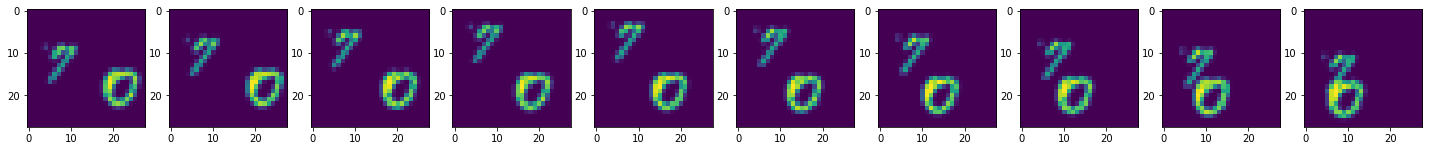

Selected input frames: 


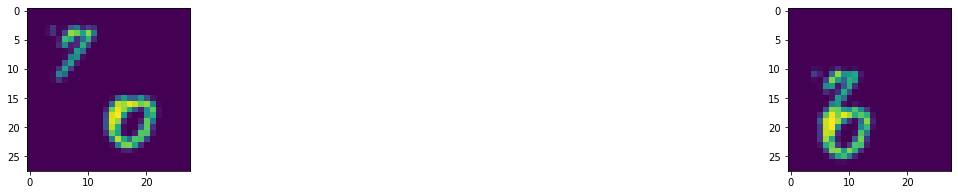

In [0]:
print("Selected test set sequence {}: ".format(seq))
sequence = test_data[:,seq,:,:]
fig=plt.figure(figsize=(25,3))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    img = toTensor(transform(toPil(test_data[i-1, seq,:,:]))).numpy().squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
if log:
  fig.savefig(work_path + "/groundtruth_sequence.svg")
# Choose frames of the video
if use_custom_frames:
  input_idx = custom_frames
else:
  if num_input==2: input_idx = [0,9]
  elif num_input==4: input_idx = [0,3,6,9]
  elif num_input==10: input_idx = [7,8,9,10,11,12,13,14,15,16]#[0,1,2,3,4,5,6,7,8,9]
  else: raise NotImplementedError

input_frames = []
for idx in input_idx:
  input_frames.append(toTensor(transform(toPil(test_data[idx, seq,:,:]))))
print("Selected input frames: ")
fig=plt.figure(figsize=(25,3))
columns = len(input_frames)
rows = 1
for i in range(1, columns*rows +1):
    img = toTensor(transform(toPil(test_data[input_idx[i-1], seq,:,:]))).numpy().squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
if log:
  fig.savefig(work_path + "/input_frames.svg")

**Load our trained GAN**

In [0]:
%cd /root/video_interpolation
import torch
import torch.nn as nn
from backprojection.bfgs import BFGSProjector
from interpolate_latent.functions import *
from models.wgan import Generator, Discriminator

netG = torch.load('/content/gdrive/My Drive/ADL4CV/Code_LSVG/Logs/21.01.2020-17:33:21/models/g.pt',map_location=torch.device('cpu'))
netG.double().cpu()

if d_correct_backprojection or d_correct_output:
  netD = torch.load('/content/gdrive/My Drive/ADL4CV/Code_LSVG/Logs/21.01.2020-17:33:21/models/d.pt', map_location=torch.device('cpu'))
  proj = CriticProjector(netG, netD, torch.device('cpu'))


/root/video_interpolation


**Backproject input images**

In [0]:
from skimage.measure import compare_mse
import models.pnet
pnet = torch.load("/content/gdrive/My Drive/ADL4CV/Code_LSVG/pnet_64.pt", map_location=torch.device("cpu"))
pnet.eval().double()
for parameter in pnet.parameters():
  parameter.requires_grad= False
def backproject(input, counter):
  projector_1 = BFGSProjector(netG, 16, device='cpu', method = 'L-BFGS-B', loss = nn.BCELoss(), tol = None)
  #projector_2 = BFGSProjector(netG, 16, device='cpu', method = 'L-BFGS-B', loss = nn.BCELoss(), tol = 1e-20)
  z0 = pnet(input.double().unsqueeze(0))
  #z0_noisy = z0 + torch.randn(1,16)*0.5
  #input = input.cuda()
  z_1 = projector_1.project(input.double().unsqueeze(0), x0 = z0)
  #z_2 = projector_2.project(input.double().unsqueeze(0), x0 = z0)
  #z_3 = projector_2.project(input.double().unsqueeze(0), x0 = z_1.x)
  #z_4 = projector_1.project(input.double().unsqueeze(0), x0 = z_2.x)
  img_init = netG(z0)
  res_img_1 = netG(torch.from_numpy(z_1.x))
  if d_correct_backprojection:
    z_proj = proj.project(z_1.x, projection_iters)
    img_proj = netG(z_proj)

  #res_img_2 = netG(torch.from_numpy(z_2.x))
  #res_img_3 = netG(torch.from_numpy(z_3.x))
  #res_img_4 = netG(torch.from_numpy(z_4.x))
  
  #img_noise = netG(z0_noisy)

  if d_correct_backprojection:
    fig = plt.figure(figsize=(16, 8))
    sp_6 = fig.add_subplot(1, 4, 1)
    sp_6.title.set_text("Pnet backprojection")
    plt.imshow(img_init.detach().squeeze())
    sp_1 = fig.add_subplot(1, 4, 2)
    sp_1.title.set_text("L-BFGS-B optimized")
    plt.imshow(res_img_1.detach().squeeze())
    sp_3 = fig.add_subplot(1, 4, 3)
    sp_3.title.set_text("L-BFGS-B + D-correction")
    plt.imshow(img_proj.detach().squeeze())
    sp_5 = fig.add_subplot(1, 4, 4)
    sp_5.title.set_text("Ground truth")
    plt.imshow(input.squeeze())
  else:
    fig = plt.figure(figsize=(12, 8))
    sp_6 = fig.add_subplot(1, 3, 1)
    sp_6.title.set_text("Pnet backprojection")
    plt.imshow(img_init.detach().squeeze())
    sp_1 = fig.add_subplot(1, 3, 2)
    sp_1.title.set_text("L-BFGS-B optimized")
    plt.imshow(res_img_1.detach().squeeze())
    #sp_2 = fig.add_subplot(1, 6, 2)
    #sp_2.title.set_text("BCE")
    #plt.imshow(res_img_2.detach().squeeze())
    #sp_3 = fig.add_subplot(1, 6, 3)
    #sp_3.title.set_text("MSE --> BCE")
    #plt.imshow(res_img_3.detach().squeeze())
    #sp_4 = fig.add_subplot(1, 6, 4)
    #sp_4.title.set_text("BCE --> MSE")
    #plt.imshow(res_img_4.detach().squeeze())
    sp_5 = fig.add_subplot(1, 3, 3)
    sp_5.title.set_text("Ground truth")
    plt.imshow(input.squeeze())
  
  #fig.add_subplot(1, 4, 7)
  #plt.imshow(img_noise.detach().squeeze())
  plt.show()
  print(z_1.message)
  #print(z_1.x)
  #print(z_2)
  #print(z_3)
  #print(z_4)
  #CALCULATE MSE
  if d_correct_backprojection:
    mse = compare_mse(input.detach().numpy().squeeze(), img_proj.detach().numpy().squeeze())
    print("MSE (ground truth vs. L-BFGS-B + D-correction): {}.".format(mse))
  else:
    mse = compare_mse(input.detach().numpy().squeeze(), res_img_1.detach().numpy().squeeze())
    print("MSE (ground truth vs. L-BFGS-B): {}.".format(mse))
  if log:
    if d_correct_backprojection:
      fig.savefig(work_path + "/backprojection_input_frame_"+str(counter)+"_d_corrected.svg")
    else:
      fig.savefig(work_path + "/backprojection_input_frame_"+str(counter)+".svg")
  return z_1.x, mse

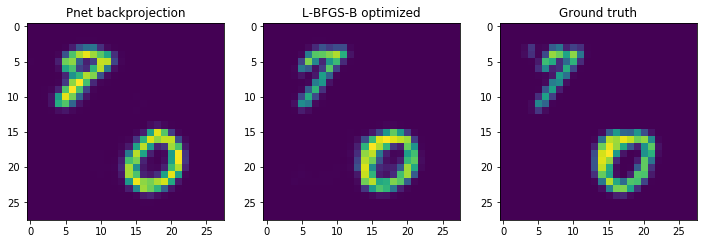

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
MSE (ground truth vs. L-BFGS-B): 0.002407959058737354.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


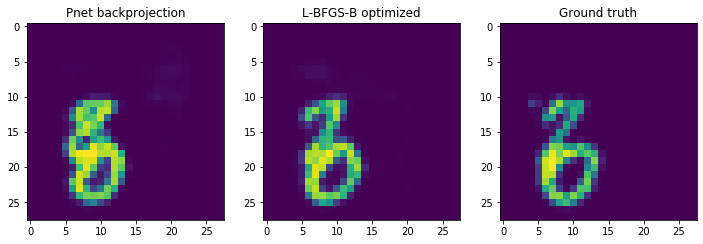

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
MSE (ground truth vs. L-BFGS-B): 0.0042294947858557445.


In [0]:
latent_video_in = []
mse_list = []
counter = 0
for frame in input_frames:
  latent_vector, mse = backproject(frame, counter)
  latent_video_in.append(latent_vector)
  mse_list.append(mse)
  counter += 1
if log:
  if d_correct_backprojection:
    with open(work_path + "/backprojected_input_frames_latent_vectors_d_corrected.pkl", 'wb') as f:
      pickle.dump(latent_video_in, f)
    with open(work_path + "/backprojected_input_frames_mse_d_corrected.pkl", 'wb') as f2:
      pickle.dump(mse_list, f2)
  else:
    with open(work_path + "/backprojected_input_frames_latent_vectors.pkl", 'wb') as f:
      pickle.dump(latent_video_in, f)
    with open(work_path + "/backprojected_input_frames_mse.pkl", 'wb') as f2:
      pickle.dump(mse_list, f2)

**Perform PCA**

In [0]:
if use_pca:
  from sklearn.decomposition import PCA
  pca = PCA(.9999)
  pca.fit(latent_video_in)
  print("Number of principal components: {}".format(pca.n_components_))
  latent_video_in_pca = pca.transform(latent_video_in)
  l1_errors=[]
  for i in range(len(latent_video_in)):
    l1_errors.append(np.abs(np.mean(np.abs(pca.inverse_transform(latent_video_in_pca[i])-latent_video_in[i]))))

  print("Mean L1-error in backtransform: {} \n Max L1-error in backtransform: {}".format(np.mean(l1_errors), np.max(l1_errors)))
  if log:
    if d_correct_backprojection:
      with open(work_path + "/backprojected_input_frames_latent_vectors_d_corrected_PCA.pkl", 'wb') as f:
        pickle.dump(latent_video_in_pca, f)
    else:
      with open(work_path + "/backprojected_input_frames_latent_vectors_PCA.pkl", 'wb') as f:
        pickle.dump(latent_video_in_pca, f)


In [0]:
for i in range(len(latent_video_in)):
  fig = plt.figure(figsize=(8, 8))

  plt1 = fig.add_subplot(1, 2, 1)
  plt1.title.set_text("Before PCA")
  plt.imshow(netG(torch.from_numpy(latent_video_in[i])).detach().squeeze())
  plt2 = fig.add_subplot(1, 2, 2)
  plt2.title.set_text("After PCA")
  plt.imshow(netG(torch.from_numpy(pca.inverse_transform(latent_video_in_pca[i]))).detach().squeeze())
  plt.show()
  if log:
    if d_correct_backprojection:
      fig.savefig(work_path + "/backprojection_input_d_corrected_PCA_frame_"+str(i)+".svg")
    else:
      fig.savefig(work_path + "/backprojection_input_PCA_frame_"+str(i)+".svg")

**Generate video frames in latent space**

In [0]:
if use_pca:
  if mode == "framerate_upsampling" or mode == "all":
    if method == "all":
      latent_video_linear_framerate_upsampling_pca = pca.inverse_transform(latentVectorInterpolate(latent_video_in_pca, output_count = num_output, method = "linear"))
      latent_video_quadratic_framerate_upsampling_pca = pca.inverse_transform(latentVectorInterpolate(latent_video_in_pca, output_count = num_output, method = "quadratic"))
      latent_video_cubic_framerate_upsampling_pca = pca.inverse_transform(latentVectorInterpolate(latent_video_in_pca, output_count = num_output, method = "cubic"))
      if d_correct_output:
        latent_video_linear_framerate_upsampling_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_framerate_upsampling_pca]
        latent_video_quadratic_framerate_upsampling_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_framerate_upsampling_pca]
        latent_video_cubic_framerate_upsampling_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_framerate_upsampling_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      latent_video_customrank_framerate_upsampling_pca = []
      for rank in range(1,11):
        if d_correct_output:
          latent_video_customrank_framerate_upsampling_pca.append([proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in pca.inverse_transform(latentVectorInterpolate(latent_video_in_pca, output_count = num_output, method = "customrank", rank = rank))])
        else:
          latent_video_customrank_framerate_upsampling_pca.append(pca.inverse_transform(latentVectorInterpolate(latent_video_in_pca, output_count = num_output, method = "customrank", rank = rank)))

      if log:
        with open(work_path + "/latent_video_framerate_upsampling_PCA_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_framerate_upsampling_pca, f)
        with open(work_path + "/latent_video_framerate_upsampling_PCA_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_framerate_upsampling_pca, f2)
        with open(work_path + "/latent_video_framerate_upsampling_PCA_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_framerate_upsampling_pca, f3)
        with open(work_path + "/latent_video_framerate_upsampling_PCA_customrank"+d_correct_appendix+".pkl", 'wb') as f4:
          pickle.dump(latent_video_customrank_framerate_upsampling_pca, f4)
    else:
      latent_video_framerate_upsampling_pca = latentVectorInterpolate(latent_video_in, output_count = 10, method = method)
      if d_correct_output:
        latent_video_framerate_upsampling_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_framerate_upsampling_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_framerate_upsampling_PCA_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_framerate_upsampling_pca, f)

  if mode == "future_video" or mode == "all":
    if method == "all":
      latent_video_linear_future_video_pca = pca.inverse_transform(latentVectorExtrapolateForward(latent_video_in_pca, output_count = num_output, method = "linear", step_ratio = 0.1))
      latent_video_quadratic_future_video_pca = pca.inverse_transform(latentVectorExtrapolateForward(latent_video_in_pca, output_count = num_output, method = "quadratic", step_ratio = 0.1))
      latent_video_cubic_future_video_pca = pca.inverse_transform(latentVectorExtrapolateForward(latent_video_in_pca, output_count = num_output, method = "cubic", step_ratio = 0.1))
      if d_correct_output:
        latent_video_linear_future_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_future_video_pca]
        latent_video_quadratic_future_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_future_video_pca]
        latent_video_cubic_future_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_future_video_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_future_video_PCA_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_future_video_pca, f)
        with open(work_path + "/latent_video_future_video_PCA_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_future_video_pca, f2)
        with open(work_path + "/latent_video_future_video_PCA_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_future_video_pca, f3)
    else:
      latent_video_future_video_pca = pca.inverse_transform(latentVectorExtrapolateForward(latent_video_in_pca, output_count = num_output, method = method, step_ratio = 0.1))
      if d_correct_output:
        latent_video_future_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_future_video_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_future_video_PCA_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_future_video_pca, f)
  
  if mode == "past_video" or mode == "all":
    if method == "all":
      latent_video_linear_past_video_pca = pca.inverse_transform(latentVectorExtrapolateBackward(latent_video_in_pca, output_count = num_output, method = "linear", step_ratio = 1))
      latent_video_quadratic_past_video_pca = pca.inverse_transform(latentVectorExtrapolateBackward(latent_video_in_pca, output_count = num_output, method = "quadratic", step_ratio = 1))
      latent_video_cubic_past_video_pca = pca.inverse_transform(latentVectorExtrapolateBackward(latent_video_in_pca, output_count = num_output, method = "cubic", step_ratio = 1))
      if d_correct_output:
        latent_video_linear_past_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_past_video_pca]
        latent_video_quadratic_past_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_past_video_pca]
        latent_video_cubic_past_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_past_video_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_past_video_PCA_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_past_video_pca, f)
        with open(work_path + "/latent_video_past_video_PCA_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_past_video_pca, f2)
        with open(work_path + "/latent_video_past_video_PCA_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_past_video_pca, f3)
    else:
      latent_video_past_video_pca = pca.inverse_transform(latentVectorExtrapolateBackward(latent_video_in_pca, output_count = num_output, method = method, step_ratio = 1))
      if d_correct_output:
        latent_video_past_video_pca = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_past_video_pca]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_past_video_PCA_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_past_video_pca, f)


if use_nonpca: 

  if mode == "framerate_upsampling" or mode == "all":
    if method == "all":
      latent_video_linear_framerate_upsampling = latentVectorInterpolate(latent_video_in, output_count = num_output, method = "linear")
      latent_video_quadratic_framerate_upsampling = latentVectorInterpolate(latent_video_in, output_count = num_output, method = "quadratic")
      latent_video_cubic_framerate_upsampling = latentVectorInterpolate(latent_video_in, output_count = num_output, method = "cubic")
      if d_correct_output:
        latent_video_linear_framerate_upsampling = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_framerate_upsampling]
        latent_video_quadratic_framerate_upsampling = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_framerate_upsampling]
        latent_video_cubic_framerate_upsampling = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_framerate_upsampling]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      latent_video_customrank_framerate_upsampling = []
      for rank in range(1,11):
        if d_correct_output:
          latent_video_customrank_framerate_upsampling.append([proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latentVectorInterpolate(latent_video_in, output_count = num_output, method = "customrank", rank = rank)])
        else:
          latent_video_customrank_framerate_upsampling.append(latentVectorInterpolate(latent_video_in, output_count = num_output, method = "customrank", rank = rank))
      if log:
        with open(work_path + "/latent_video_framerate_upsampling_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_framerate_upsampling, f)
        with open(work_path + "/latent_video_framerate_upsampling_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_framerate_upsampling, f2)
        with open(work_path + "/latent_video_framerate_upsampling_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_framerate_upsampling, f3)
        with open(work_path + "/latent_video_framerate_upsampling_customrank"+d_correct_appendix+".pkl", 'wb') as f4:
          pickle.dump(latent_video_customrank_framerate_upsampling, f4)
    else:
      latent_video_framerate_upsampling = latentVectorInterpolate(latent_video_in, output_count = num_output, method = method)
      if d_correct_output:
        latent_video_framerate_upsampling = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_framerate_upsampling]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_framerate_upsampling_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_framerate_upsampling, f)

  if mode == "past_video" or mode == "all":
    if method == "all":
      latent_video_linear_past_video = latentVectorExtrapolateBackward(latent_video_in, output_count = num_output, method = "linear", step_ratio = 1)
      latent_video_quadratic_past_video = latentVectorExtrapolateBackward(latent_video_in, output_count = num_output, method = "quadratic", step_ratio = 1)
      latent_video_cubic_past_video = latentVectorExtrapolateBackward(latent_video_in, output_count = num_output, method = "cubic", step_ratio = 1)
      if d_correct_output:
        latent_video_linear_past_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_past_video]
        latent_video_quadratic_past_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_past_video]
        latent_video_cubic_past_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_past_video]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_past_video_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_past_video, f)
        with open(work_path + "/latent_video_past_video_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_past_video, f2)
        with open(work_path + "/latent_video_past_video_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_past_video, f3)
    else:
      latent_video_past_video = latentVectorExtrapolateBackward(latent_video_in, output_count = num_output, method = method, step_ratio = 1)
      if d_correct_output:
        latent_video_past_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_past_video]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_past_video_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_past_video, f)

  if mode == "future_video" or mode == "all":
    if method == "all":
      latent_video_linear_future_video = latentVectorExtrapolateForward(latent_video_in, output_count = num_output, method = "linear", step_ratio = 1)
      latent_video_quadratic_future_video = latentVectorExtrapolateForward(latent_video_in, output_count = num_output, method = "quadratic", step_ratio = 1)
      latent_video_cubic_future_video = latentVectorExtrapolateForward(latent_video_in, output_count = num_output, method = "cubic", step_ratio = 1)
      if d_correct_output:
        latent_video_linear_future_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_linear_future_video]
        latent_video_quadratic_future_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_quadratic_future_video]
        latent_video_cubic_future_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_cubic_future_video]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_future_video_linear"+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_linear_future_video, f)
        with open(work_path + "/latent_video_future_video_quadratic"+d_correct_appendix+".pkl", 'wb') as f2:
          pickle.dump(latent_video_quadratic_future_video, f2)
        with open(work_path + "/latent_video_future_video_cubic"+d_correct_appendix+".pkl", 'wb') as f3:
          pickle.dump(latent_video_cubic_future_video, f3)
    else:
      latent_video_future_video = latentVectorExtrapolateForward(latent_video_in, output_count = num_output, method = method, step_ratio = 1)
      if d_correct_output:
        latent_video_future_video = [proj.project(vec, projection_iters).detach().numpy().squeeze() for vec in latent_video_future_video]
        d_correct_appendix = "_d_corrected"
      else:
        d_correct_appendix = ""
      if log:
        with open(work_path + "/latent_video_future_video_"+method+d_correct_appendix+".pkl", 'wb') as f:
          pickle.dump(latent_video_future_video, f)


**Generate video frames in image space**

Output video for mode framerate_upsampling with interpolation method [linear]:


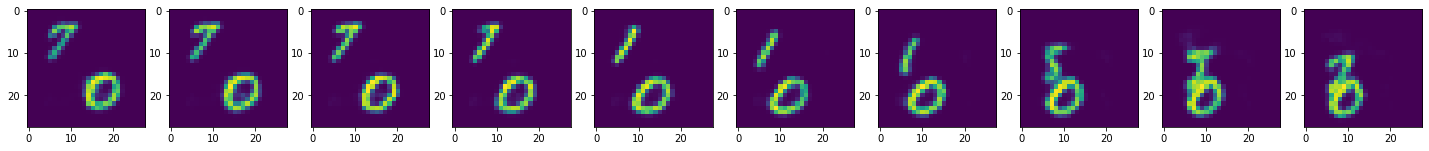

In [0]:
if d_correct_output and d_correct_backprojection:
  d_correct_appendix = "_d_corrected_in_out_"
elif d_correct_output:
  d_correct_appendix = "_d_corrected_out_"
elif d_correct_backprojection:
  d_correct_appendix = "_d_corrected_in_"
else:
  d_correct_appendix = ""

if d_correct_output:
  print_appendix = " and D-correction"
else:
  print_appendix = ""

if use_pca:
  if mode == "framerate_upsampling" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_framerate_upsampling_pca)
      plot_counter = 1

      for latent_frame in latent_video_linear_framerate_upsampling_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [linear] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_framerate_upsampling_pca"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_framerate_upsampling_pca)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_framerate_upsampling_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [quadratic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_framerate_upsampling_pca"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_framerate_upsampling_pca)
      plot_counter = 1

      for latent_frame in latent_video_cubic_framerate_upsampling_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [cubic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_framerate_upsampling_pca"+d_correct_appendix+".svg") 

      for rank in range(10):
        fig=plt.figure(figsize=(25,3))
        columns = len(latent_video_cubic_framerate_upsampling_pca)
        plot_counter = 1

        for latent_frame in latent_video_customrank_framerate_upsampling_pca[rank]:
          frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
          fig.add_subplot(1, columns, plot_counter)
          plot_counter += 1
          plt.imshow(frame_gen)
        print("Output video for mode framerate_upsampling with custom interpolation rank {} with PCA"+print_appendix+":".format(rank+1))
        plt.show() 
        if log:
          fig.savefig(work_path + "/output_video_custom_rank_"+str(rank+1)+"_framerate_upsampling_pca"+d_correct_appendix+".svg") 

    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_framerate_upsampling_pca)
      plot_counter = 1

      for latent_frame in latent_video_framerate_upsampling_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [" + method + "] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_framerate_upsampling_pca"+d_correct_appendix+".svg")

  if mode == "future_video" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_future_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_linear_future_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [linear] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_future_video_pca"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_future_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_future_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [quadratic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_future_video_pca"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_future_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_cubic_future_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [cubic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_future_video_pca"+d_correct_appendix+".svg") 

    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_future_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_future_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [" + method + "] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_future_video_pca"+d_correct_appendix+".svg")

  if mode == "past_video" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_past_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_linear_past_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [linear] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_past_video_pca"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_past_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_past_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [quadratic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_past_video_pca"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_past_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_cubic_past_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [cubic] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_past_video_pca"+d_correct_appendix+".svg") 
    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_past_video_pca)
      plot_counter = 1

      for latent_frame in latent_video_past_video_pca:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [" + method + "] with PCA"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_past_video_pca"+d_correct_appendix+".svg")

if use_nonpca:
  if mode == "framerate_upsampling" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_framerate_upsampling)
      plot_counter = 1

      for latent_frame in latent_video_linear_framerate_upsampling:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [linear]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_framerate_upsampling"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_framerate_upsampling)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_framerate_upsampling:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [quadratic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_framerate_upsampling"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_framerate_upsampling)
      plot_counter = 1

      for latent_frame in latent_video_cubic_framerate_upsampling:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode framerate_upsampling with interpolation method [cubic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_framerate_upsampling"+d_correct_appendix+".svg") 

      for rank in range(10):
        fig=plt.figure(figsize=(25,3))
        columns = len(latent_video_cubic_framerate_upsampling)
        plot_counter = 1

        for latent_frame in latent_video_customrank_framerate_upsampling[rank]:
          frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
          fig.add_subplot(1, columns, plot_counter)
          plot_counter += 1
          plt.imshow(frame_gen)
        print("Output video for mode framerate_upsampling with custom interpolation rank {}"+print_appendix+":".format(rank+1))
        plt.show() 
        if log:
          fig.savefig(work_path + "/output_video_custom_rank_"+str(rank+1)+"_framerate_upsampling"+d_correct_appendix+".svg") 

    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_framerate_upsampling)
      plot_counter = 1

      for latent_frame in latent_video_framerate_upsampling:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)

        #SAVEHERE
        toPil(netG(torch.from_numpy(latent_frame)).detach().squeeze().float()).save(os.path.join(work_path, str(plot_counter)+'.png'), 'PNG')
      print("Output video for mode framerate_upsampling with interpolation method [" + method + "]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_framerate_upsampling"+d_correct_appendix+".svg")

  if mode == "future_video" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_future_video)
      plot_counter = 1

      for latent_frame in latent_video_linear_future_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [linear]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_future_video"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_future_video)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_future_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [quadratic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_future_video"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_future_video)
      plot_counter = 1

      for latent_frame in latent_video_cubic_future_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [cubic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_future_video"+d_correct_appendix+".svg") 

    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_future_video)
      plot_counter = 1

      for latent_frame in latent_video_future_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode future_video with interpolation method [" + method + "]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_future_video"+d_correct_appendix+".svg")

  if mode == "past_video" or mode == "all":
    if method == "all":
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_linear_past_video)
      plot_counter = 1

      for latent_frame in latent_video_linear_past_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [linear]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_linear_past_video"+d_correct_appendix+".svg")

      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_quadratic_past_video)
      plot_counter = 1

      for latent_frame in latent_video_quadratic_past_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [quadratic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_quadratic_past_video"+d_correct_appendix+".svg")
      
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_cubic_past_video)
      plot_counter = 1

      for latent_frame in latent_video_cubic_past_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [cubic]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_cubic_past_video"+d_correct_appendix+".svg") 
    else:
      fig=plt.figure(figsize=(25,3))
      columns = len(latent_video_past_video)
      plot_counter = 1

      for latent_frame in latent_video_past_video:
        frame_gen = netG(torch.from_numpy(latent_frame)).detach().numpy().squeeze()
        fig.add_subplot(1, columns, plot_counter)
        plot_counter += 1
        plt.imshow(frame_gen)
      print("Output video for mode past_video with interpolation method [" + method + "]"+print_appendix+":")
      plt.show()
      if log:
        fig.savefig(work_path + "/output_video_"+method+"_past_video"+d_correct_appendix+".svg")

**--- BACKUP SNIPPETS ---**

**Choose input latent vectors by hand**

In [0]:
latent_vectors_chosen=[]

In [0]:
latent_vectors = []
fig=plt.figure(figsize=(25,25))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    noise = torch.randn(1, 16)
    latent_vectors.append(noise)
    noisev = nn.Parameter(noise).double()
    pred = nn.Parameter(netG(noisev))
    img = pred.detach().numpy().squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

**Choose images from list**

In [0]:

#latent_vectors_chosen.append(latent_vectors[40])
fig=plt.figure(figsize=(3*len(latent_vectors_chosen),3))
columns = len(latent_vectors_chosen)
rows = 1
for i in range(1, columns*rows +1):
    input_vector = nn.Parameter(latent_vectors_chosen[i-1]).double()
    pred = nn.Parameter(netG(input_vector))
    img = pred.detach().numpy().squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
import pickle
with open('/content/gdrive/My Drive/ADL4CV/Code_LSVG/encoded_sequence_9and0.pkl', 'wb') as f:
  pickle.dump(latent_vectors_chosen, f)

In [0]:
if not  os.path.exists("/content/gdrive/My Drive/ADL4CV/Code_LSVG/Results/handpicked_2"):
  os.makedirs("/content/gdrive/My Drive/ADL4CV/Code_LSVG/Results/handpicked_2")
fig.savefig("/content/gdrive/My Drive/ADL4CV/Code_LSVG/Results/handpicked_2/input.svg")

In [0]:
print([vec.numpy().squeeze() for vec in latent_vectors_chosen[0:2]])

In [0]:
latent_video = latentVectorInterpolate([vec.numpy().squeeze() for vec in latent_vectors_chosen[0:2]], output_count = 10, method = "linear")
fig=plt.figure(figsize=(30,3))
columns = len(latent_video)
plot_counter = 1

for latent_frame in latent_video:
  frame_gen = netG(latent_frame.double()).detach().numpy().squeeze()
  fig.add_subplot(1, columns, plot_counter)
  plot_counter += 1
  plt.imshow(frame_gen)
plt.show()

In [0]:
fig.savefig("/content/gdrive/My Drive/ADL4CV/Code_LSVG/Results/handpicked_2/output.svg")

**Load backprojected latent vectors**

In [0]:
import pickle
from skimage.measure import compare_mse
latent_video_in = []
if seq == 554:
  with open('/content/gdrive/My Drive/ADL4CV/Code_LSVG/encoded_sequence_new.pkl', 'rb') as f:
    latent_video_in = pickle.load(f)

**Display backprojected latent vectors and their ground truth frame**

In [0]:
for i in range(len(latent_video_in)):
  res_img = netG(torch.from_numpy(latent_video_in[i]))
  fig = plt.figure(figsize=(8, 8))
  fig.add_subplot(1, 2, 1)
  plt.imshow(res_img.detach().squeeze())
  fig.add_subplot(1, 2, 2)
  plt.imshow(input_frames[i].squeeze())
  plt.show()
  #CALCULATE MSE
  print("MSE: {}.".format(compare_mse(input_frames[i].numpy().squeeze(), res_img.detach().numpy().squeeze())))